### Load and transform textual script data

In [44]:
import pandas as pd

# Get scripts data
script_csv_path = "./processed_data/combined_script_data.csv"
script_data = pd.read_csv(script_csv_path)
script_data = script_data.drop(columns=["release_year"])
# display(script_data)

# Get Oscar labels
oscar_labels_path = "./processed_data/oscar_data.csv"
oscar_label = pd.read_csv(oscar_labels_path).rename(columns={"entity": "title", "category": "nominated", "winner": "won"})
oscar_label = oscar_label.drop(columns=["year"])
oscar_label["nominated"] = True
# display(oscar_label)

# Merge script and Oscar data
script_oscar_df = pd.merge(script_data, oscar_label, how="outer", on="title")
script_oscar_df = script_oscar_df.dropna(subset=['script'])
script_oscar_df = script_oscar_df.fillna(False)
# display(script_oscar_df)

script_oscar_df['nominated'].astype('bool')
script_oscar_df['won'].astype('bool')
# print(script_oscar_df.dtypes)
# display(script_oscar_df)

script_oscar_df = script_oscar_df[script_oscar_df['nominated'] == script_oscar_df['won']].drop_duplicates()
script_oscar_df = script_oscar_df.drop(columns=['nominated'])
script_oscar_df['won'] = script_oscar_df['won'].astype(int)
display(script_oscar_df)

script_oscar_df.reset_index()
print('Done')

,title,script,won
1,When Worlds Collide,needl heaven haystack star heaven human earth ...,1
5,Reds,rememb im begin forget peopl use know rememb l...,1
12,Undefeated,let start right guard shot longer school start...,1
15,Seven Brides for Seven Brothers,deliv perfectionand dont brag d pound beaver w...,1
25,Henry V,oh muse ascend brightest heaven invent kingdom...,1
...,...,...,...
7441,The Roommate,hi hi sara matthew sara matthew room welcom th...,0
7442,Night of the Comet,record time swung univers ellipt orbit larg ex...,0
7443,Paddington,darkest peru vast unexplor wilder shroud myste...,0
7444,Jumanji: Welcome to the Jungle,ocean wave crash seagul squawk drum beat rhyth...,0


Done


In [45]:
features,labels = script_oscar_df['script'],script_oscar_df['won']
print('done')

done


### Create tfidf

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

def build_tfidf(xtrain):
    vectorizer = TfidfVectorizer(max_features=10000, min_df=0.05, max_df=0.5)
    # Fit the vectorizer here
    vectorizer.fit(xtrain)
    return vectorizer

xtrain, xtest, ytrain, ytest = train_test_split(features, labels, random_state=0, test_size=0.2, stratify=labels)

print('Vectorizing data with tfidf...')
vectorizer = build_tfidf(xtrain)
tf_xtrain = vectorizer.transform(xtrain)
tf_xtest  = vectorizer.transform(xtest)
print('done')

Vectorizing data with tfidf...
done


### Exploratory Data Analysis

In [49]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

oscar_winners = script_oscar_df[script_oscar_df['won'] == 1]

# Cluster topics of winning movies
print('Using count vectorizer...')
count_vectorizer = CountVectorizer(max_features=10000, min_df=, max_df=0.5)
cv_vectors = count_vectorizer.fit_transform(oscar_winners['script'])
print('Training lda...')
lda = LatentDirichletAllocation(n_components=25, random_state=0)
lda.fit(cv_vectors)
for i, topic in enumerate(lda.components_, start=1):
    # Your solution
    top_indices = sorted(range(len(topic)), key=lambda i: topic[i], reverse=True)[:5]
    top_words = ' '.join([count_vectorizer.get_feature_names()[ind] for ind in top_indices])
    print('Top in '+str(i)+':', top_words)

Using count vectorizer...
Training lda...
Top in 1: continu johnni ha rabbit uh
Top in 2: fuck shit ok ass wanna
Top in 3: jane darl toni fred dad
Top in 4: captain ship general command colonel
Top in 5: thou lord thi thee senat
Top in 6: nick tom uh daisi union
Top in 7: madam japanes darl baron mari
Top in 8: jack wall comrad monsieur eve
Top in 9: uh dr um dad david
Top in 10: king lord majesti england queen
Top in 11: rome pari monsieur madam french
Top in 12: joe billi susan alic champ
Top in 13: henri howard charl margaret spanish
Top in 14: fuck shit cop wanna phone
Top in 15: lm lts lll lt lf
Top in 16: presid vote law senat court
Top in 17: lord mose king master princ
Top in 18: uh bank american german govern
Top in 19: mike frank ray michael pete
Top in 20: maam reckon frank pa butler
Top in 21: charli pa ma ben don
Top in 22: darl georg dr york coffe
Top in 23: rose master captain hors tom
Top in 24: song jimmi georg band record
Top in 25: em ya wanna sam nigger


In [47]:
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

# Do Confusion Matrix exploration on simple model
lr_clf = LogisticRegression(solver='saga', max_iter=1000).fit(tf_xtrain, ytrain)
pred = lr_clf.predict(tf_xtest)
tn, fp, fn, tp = confusion_matrix(ytest, pred).ravel()
print('Confusion matrix on simple logistic regression model:')
print('TN: {} TP: {} FP: {} FN: {}'.format(tn, tp, fp, fn))
pd.crosstab(ytest, pred, rownames=['True'], colnames=['Predicted'], margins=True)

Confusion matrix on simple logistic regression model:
TN: 511 TP: 25 FP: 6 FN: 98


Predicted,0,1,All
True,,,
0,511,6,517
1,98,25,123
All,609,31,640


### Visualize data

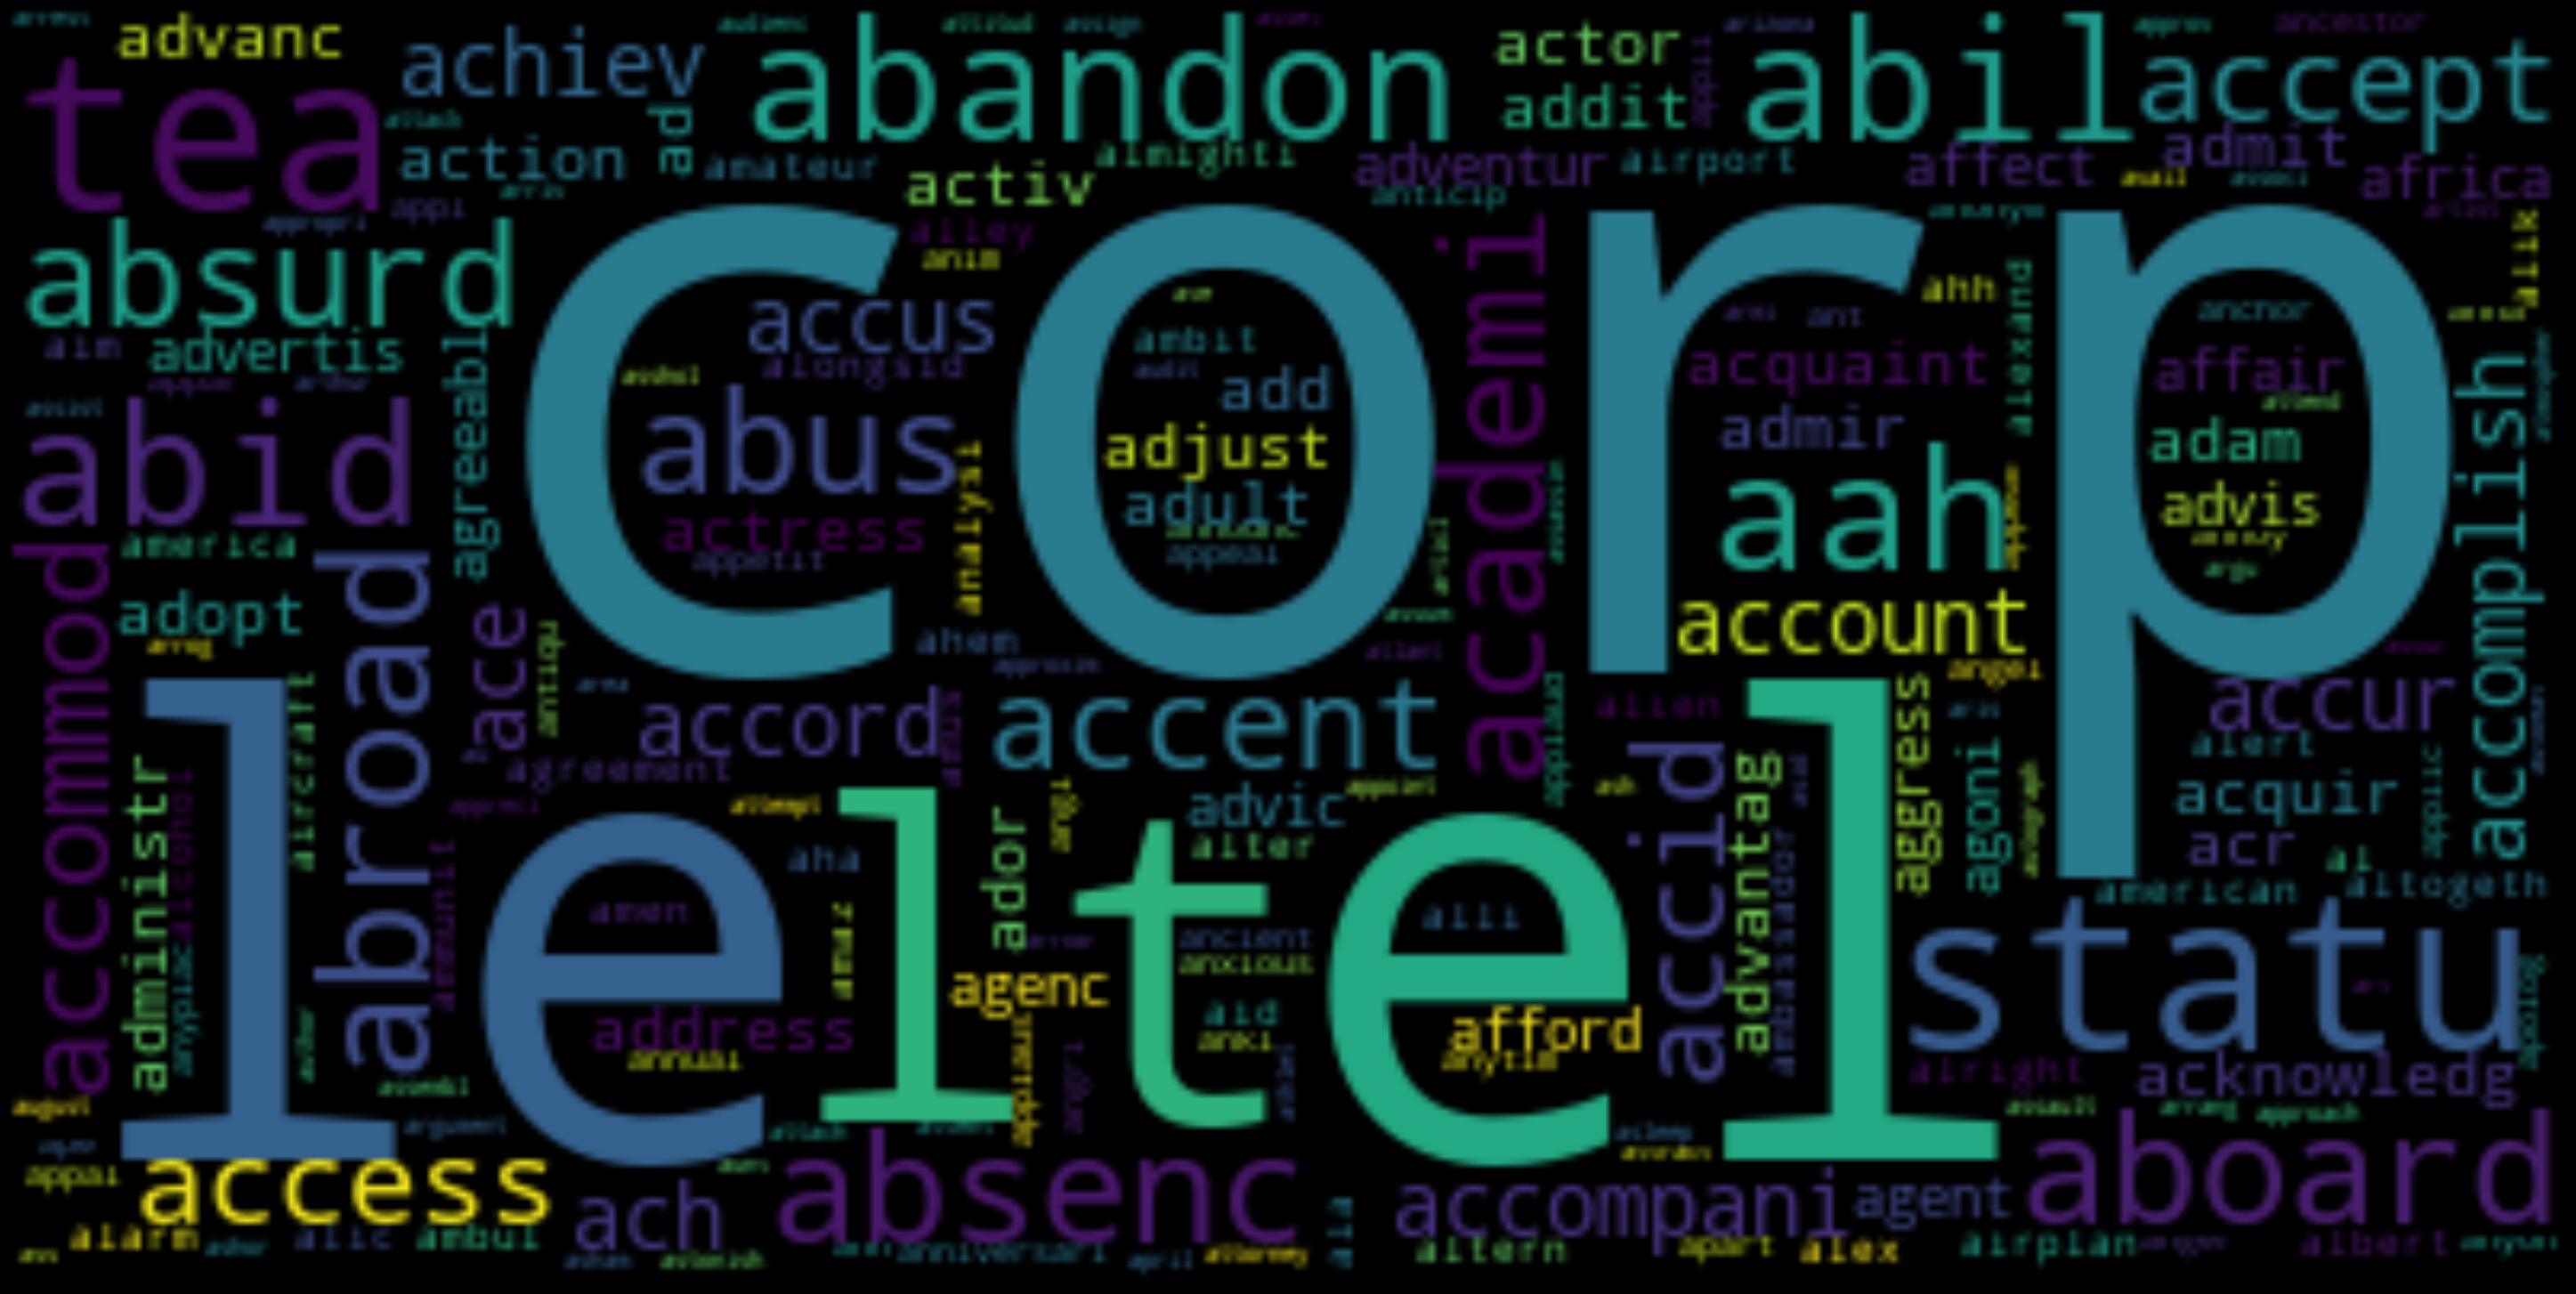

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

# Word cloud of oscar winning scripts
cloud = WordCloud().generate(' '.join(count_vectorizer.get_feature_names()))
fig = plt.figure(figsize = (40, 30), facecolor = 'k', edgecolor = 'k')
plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

### ML prediction

In [26]:
from sklearn.linear_model import LogisticRegression

print('Predicting...')
lr_clf = LogisticRegression(solver='saga').fit(tf_xtrain, ytrain)
print(lr_clf.score(tf_xtest, ytest))
print('done')

Predicting...
0.8390625
done


C:\Users\paulc\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\linear_model\sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
